# Siamese Neural Network

Siamese neural network is a class of neural network architectures that contain two or more identical sub networks. identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub networks.It is used find the similarity of the inputs by comparing its feature vectors.

For more details check this blog : https://innovationincubator.com/siamaese-neural-network-with-paytorch-code-example/

## Steps to create classifier using Siamese Neural Network 


1.   **Data Preprocessing**
2.   **Define the Siamese Network**
3.   **Feature Vector Extraction**
4.   **Similarity Score Calculation**
5.   **Defininf Loss Function**
6.   **Optimizer**
7.   **Testing using One-Shot Learnig**
8.   **Making Predictions**



Let's  go step wise 

## Import and Install all the necessary packages

In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
  ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl


In [0]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 

from google.colab import drive

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

### Additional Utility Functions 

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    drive.mount("/content/drive")
    dataset_path = "/content/drive/My Drive/att-database-of-faces/"

    training_dir =  dataset_path + 'training'
    testing_dir = dataset_path + 'testing'

    train_batch_size = 64
    train_number_epochs = 200

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Preprocessing and Loading Dataset

We preprocessed all the images and loaded them as .npy files which is easy to transfer . You can follow your own preprocessing steps .


In [0]:
class SiameseNetworkDataset():
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        # set input parameters to properties
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        # get a random image from dataset
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        # read randomly selected images
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # conver to gray scale
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # invert if required
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        # apply transform if required
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        # return number of images in dataset
        return len(self.imageFolderDataset.imgs)

In [0]:
folder_train_dataset = datasets.ImageFolder(root=Config.training_dir)

transform = transforms.Compose([transforms.Resize((100,100)),
                                transforms.ToTensor()])

train_dataset = SiameseNetworkDataset(imageFolderDataset=folder_train_dataset,
                                      transform=transform,
                                      should_invert=False)

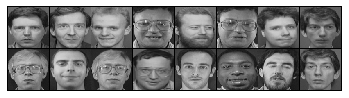

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [23]:
# Viewing the sample of images and to check whether its loading properly
vis_batch_size = 8

vis_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=vis_batch_size)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Siamese Network Definition

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork , self).__init__()
        
        self.conv_layers = nn.Sequential(
                                nn.ReplicationPad2d(1),
                                nn.Conv2d(1,4 , kernel_size = 3),
                                nn.ReLU(inplace = True),
                                nn.BatchNorm2d(4),
                                
                                nn.ReplicationPad2d(1),
                                nn.Conv2d(4,8 , kernel_size = 3),
                                nn.ReLU(inplace = True),
                                nn.BatchNorm2d(8),
        
                                nn.ReplicationPad2d(1),
                                nn.Conv2d(8,8 , kernel_size = 3),
                                nn.ReLU(inplace = True),
                                nn.BatchNorm2d(8))
        
        self.fully_connect = nn.Sequential(nn.Linear(8*100*100 , 500),
                                           nn.ReLU(inplace = True),
                                           nn.Linear(500,500),
                                           nn.ReLU(inplace = True),
                                           nn.Linear(500 , 5))
    
    def forward_once(self , x):
        output = self.conv_layers(x)
        output = output.view(output.size()[0], -1)
        output = self.fully_connect(output)
        return output
    
    def forward(self , inp1 , inp2):
        
        op1 = self.forward_once(inp1)
        op2 = self.forward_once(inp2)
        
        return op1 , op2

### Loss Function

In [0]:
class Contrastive_loss(torch.nn.Module):
    
    '''Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf'''
    def __init__(self, margin=2.0):
        super(Contrastive_loss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### Train the Model

In [0]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=Config.train_batch_size)

In [17]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [0]:
# Declare Siamese Network
net = SiameseNetwork().cuda()

# Decalre Loss Function
criterion = Contrastive_loss()

# Declare Optimizer
#optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()

            optimizer.zero_grad()

            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)

            loss_contrastive.backward()
            optimizer.step()

            if i % 50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
                
    return net

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
model = train()

# Save the model
torch.save(model.state_dict(), "/content/model.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 1.490095615386963

Epoch number 1
 Current loss 2.459136962890625

Epoch number 2
 Current loss 0.7319279909133911

Epoch number 3
 Current loss 2.6818172931671143

Epoch number 4
 Current loss 0.8208801746368408

Epoch number 5
 Current loss 1.9941163063049316

Epoch number 6
 Current loss 1.956795573234558

Epoch number 7
 Current loss 0.3286963403224945

Epoch number 8
 Current loss 0.3722672164440155

Epoch number 9
 Current loss 0.6211496591567993

Epoch number 10
 Current loss 0.4041057825088501

Epoch number 11
 Current loss 0.47388899326324463

Epoch number 12
 Current loss 0.2504633665084839

Epoch number 13
 Current loss 0.2098672091960907

Epoch number 14
 Current loss 0.2228885442018509

Epoch number 15
 Current loss 0.23134765028953552

Epoch number 16
 Current loss 0.18732020258903503

Epoch number 17
 Current loss 0.15984554588794708

Epoch number 18
 Current loss 0.1660938411951065

Epoch number 19
 Current loss 0.11594509333372116

Epoch nu

In [27]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("/content/model.pt"))

<All keys matched successfully>

In [0]:
folder_test_dataset = datasets.ImageFolder(root=Config.testing_dir)

test_dataset = SiameseNetworkDataset(imageFolderDataset=folder_test_dataset,
                                        transform=transform,
                                        should_invert=False)

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

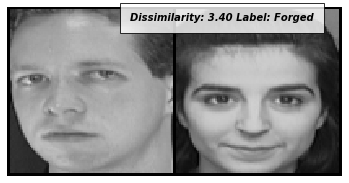

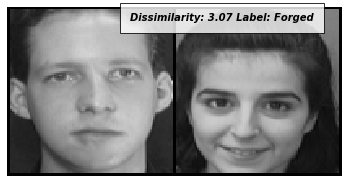

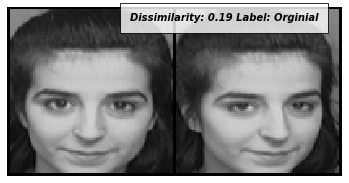

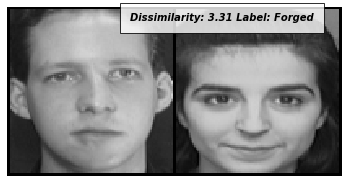

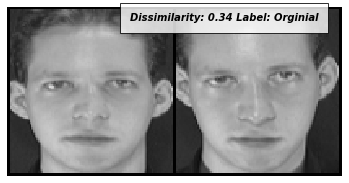

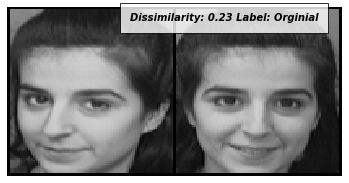

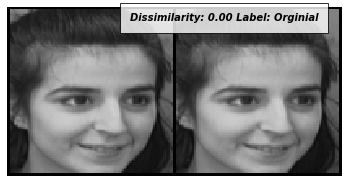

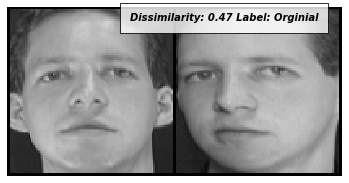

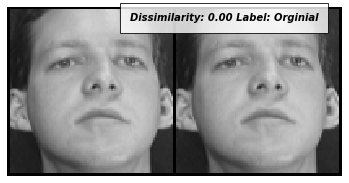

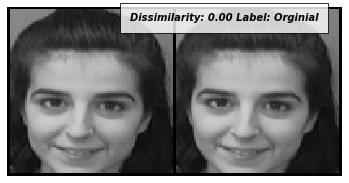

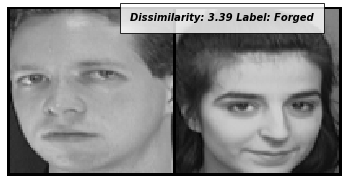

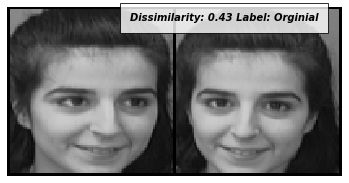

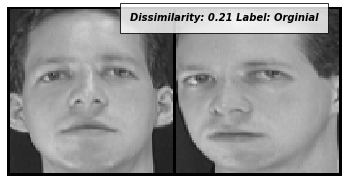

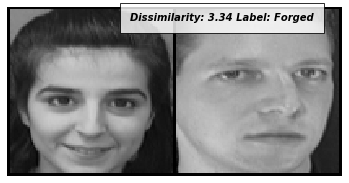

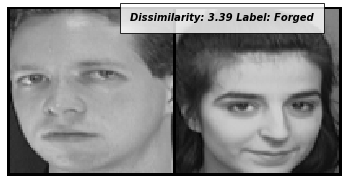

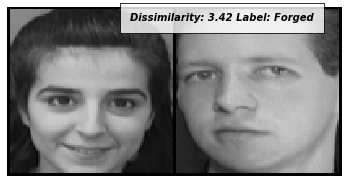

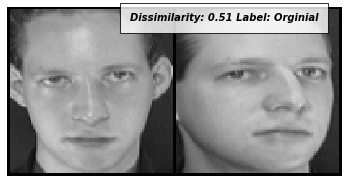

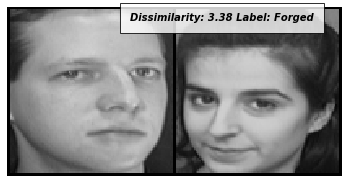

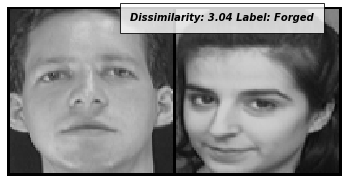

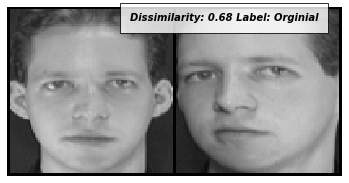

In [30]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])

for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

Dissimilarity: 2.92

Not Verified.


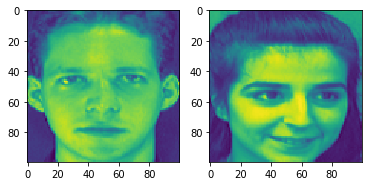

In [44]:
from PIL import Image
  
def image_loader(loader, image_name):
  image = Image.open(image_name)
  image = loader(image).float()
  image = image.unsqueeze(0)
  
  return image


def oneshot(model,img1,img2):
  # Gives you the feature vector of both inputs
  output1,output2 = model(img1.to(device),img2.to(device))

  # Compute the distance 
  euclidean_distance = F.pairwise_distance(output1, output2)

  print("Dissimilarity: %2.2f\n" % (euclidean_distance.item()))

  #with certain threshold of distance say its similar or not
  if euclidean_distance < 0.6:
    print("Verified.")
  else:
    print("Not Verified.")


# load test image
img1 = image_loader(transform, Config.testing_dir + '/s1/1.pgm')
img2 = image_loader(transform, Config.testing_dir + '/s10/3.pgm')

plt.subplot(1,2,1)
plt.imshow(img1[0][0])
plt.subplot(1,2,2)
plt.imshow(img2[0][0])

oneshot(model, img1, img2)

### Accuracy Check

In [77]:
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=True)

# face verification is not about accuracy
# this is just for test purpose
accuracy=0
counter=0
correct=0

for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 5 dense vectors
  output1,output2 = model(x0.to(device),x1.to(device))
  #res=torch.abs(output1.cuda() - output2.cuda())

  label=label[0].tolist()
  label=int(label[0])
  
  euclidean_distance = F.pairwise_distance(output1, output2)
  prediction = -1


  if (euclidean_distance.item() < 0.6):
    prediction = 0
  else:
    prediction = 1
  
  if (label == prediction):
    correct += 1

  counter += 1

accuracy=(correct/counter)*100
print("Accuracy:{}%".format(accuracy))

Accuracy:90.0%


## Final Touch 

Thats it guys ! I am limited by time , computational power and knowledge .to get standard accuracy . But anyway this is the working code of Siamese Neural Network and you can try it for your own applications and dataset.

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Thanks to Gupta Blog : https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e